# Modelling continuous data with Tensoflow Probability (TFP)

In this notebook you will learn how work with TFP. Kudos goes to 'Lars Bosshard' for starting the translation from python to R. 

* You will get to know TFP
* You will set up linear regression models that are able to output a Gaussian conditional probability distribution. 
* Define different models with Keras and the TensorFlow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution with Normal distribution with 

1. a constant, 
2. monotonic, 
3. and flexible standard deviation $\sigma$. 

The mean $\mu$ of the CPD will always depend linearly on the input. You compare the performance of the 3 models based on the NLL on a validation set and use the one with the lowest NLL to predict the test set. Finally, you will also do an extrapolation experiment with the best model and look how the predicted CPD behaves.

**Dataset:** You work with a simulated dataset that looks a bit like a fish when visualized in a scatter plot. 

**Content:**

* Work with a Normal distribution in TFP
* Simulate and split the dataset
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and a fixed standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and monotoic standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and flexible standart deviation $\sigma$ (by adding hidden layers)
* Compare the different models based on the NLL loss on the validation dataset
* Choose one of these model to predict the test dataset and calculate the NLL on the test data
* Make a extrapolation experiment with the best model and look how the predicted CPD behaves

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Installing TensorFlow Probability

Unfornuately TFP is not installed by default for Kaggle R Kernels (as of 9/15/2022). For more details/background on how to install TFP see https://www.kaggle.com/code/oduerr/tfp-with-r. This installation is for Tensorflow 2.6.5 for other versions you might need to adobt the installation procedure. 

In [4]:
library(reticulate)
use_condaenv("r-reticulate", required = TRUE) #We activate the conda enviroment
py_list_packages("r-reticulate") %>% filter(package %in% c('tensorflow', 'keras', 'tensorflow-probability'))

package,version,requirement,channel
<chr>,<chr>,<chr>,<chr>
keras,2.6.0,keras=2.6.0,pypi
tensorflow,2.6.5,tensorflow=2.6.5,pypi


** **You should see tensorflow 2.6.5** **

In [5]:
py_install('tensorflow_probability==0.14.1', pip=TRUE, envname="r-reticulate") #Installs the correct python version of TFP
py_list_packages("r-reticulate") %>% filter(package %in% c('tensorflow', 'keras', 'tensorflow-probability'))

package,version,requirement,channel
<chr>,<chr>,<chr>,<chr>
keras,2.6.0,keras=2.6.0,pypi
tensorflow,2.6.5,tensorflow=2.6.5,pypi
tensorflow-probability,0.14.1,tensorflow-probability=0.14.1,pypi


** **You should see tensorflow-probability** **

In [6]:
install.packages("tfprobability") #This installs the R-wrappers of TFP

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
library(keras)
library(tensorflow)
library(tfprobability)
d = tf$version
d$VERSION #2.6.5
tf$test$gpu_device_name() #If '/device:GPU:0' you are on a GPU. You don't need a GPU for this example

Loaded Tensorflow version 2.6.5



[1] "2.6.5"

[1] ""

## Working with a TFP distribution (Introduction)

### First Steps with distributions
Here you can see how to work with distributions in TFP. All distributions are similar, we start with a normal.

In [8]:
try(d <- tfd_normal(loc = 1.0, scale = 0.1) )# This is a strange hack to get rid of a stupid error message
d  = tfd_normal(loc = 1.0, scale = 0.1) # Create a normal distribution with mu=1 and sigma=0.1
(s = tfd_sample(d,2)) # Draw two random points, note we have tensor 
as.numeric(s) # Now, we have numeric values
s$numpy()     # Alternative use when as.numeric() makes troubles
tfd_prob(d, 3) #Compute density/mass.
tfd_cdf(d, 3) #Compute CDF
tfd_mean(d) #Compute mean (expectation)
tfd_stddev(d) #Compute std

tf.Tensor([0.89983606 0.9415055 ], shape=(2), dtype=float32)

[1] 0.8998361 0.9415055

[1] 0.8998361 0.9415055

tf.Tensor(0.0, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)

tf.Tensor(0.1, shape=(), dtype=float32)

### Simple Plotting
Let's evaluate and plot the normal distribution and a Poisson distribution.

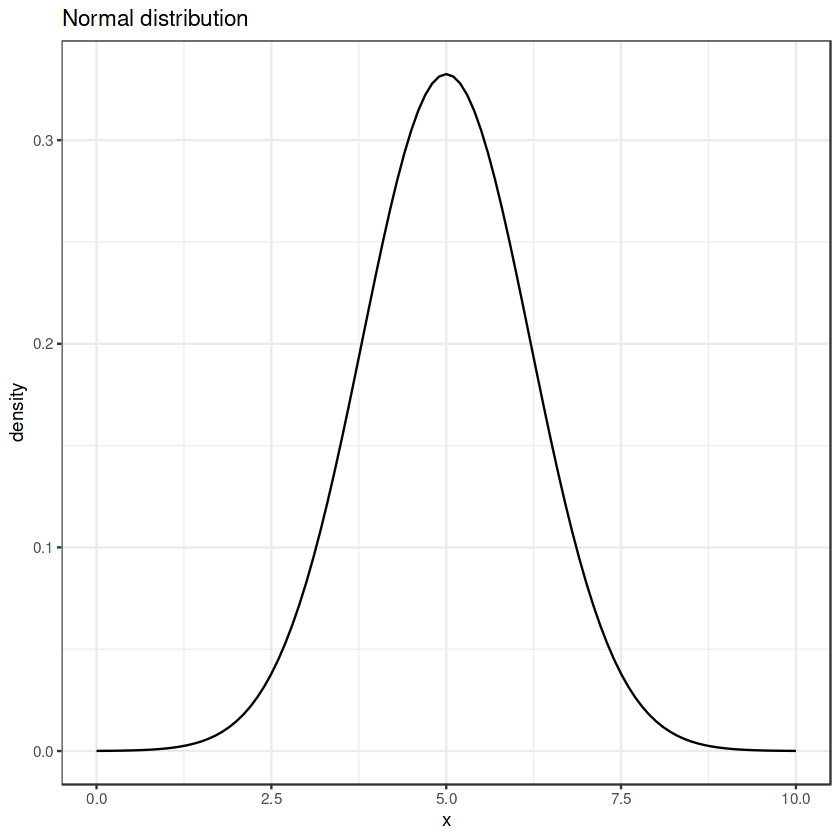

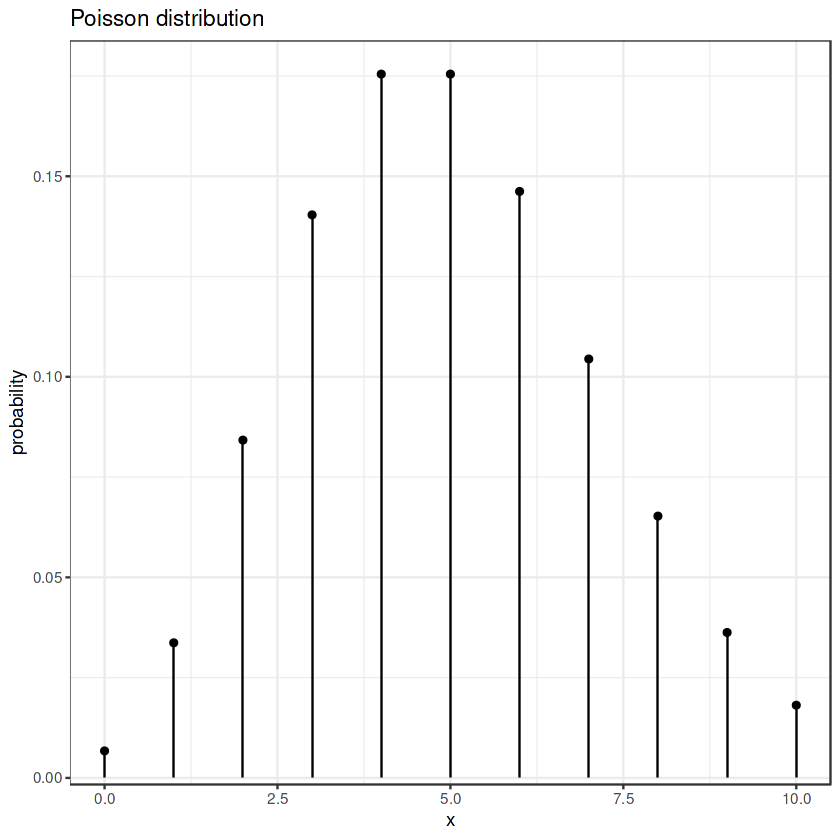

In [9]:
d <- tfd_normal(loc = 5, scale = 1.2)
px <- tfd_prob(d,seq(0,10,by=0.1))

dp <- tfd_poisson(rate = 5)
ppx <- tfd_prob(dp,seq(0,10,by=1))

data.frame(x=seq(0,10,by=0.1),density=as.numeric(px)) %>%
  ggplot(aes(x=x,y=density)) +
  geom_line() +
  ggtitle("Normal distribution") +
  theme_bw()

data.frame(x=seq(0,10,by=1),probability=as.numeric(ppx)) %>%
  ggplot(aes(x=x,y=probability)) +
  geom_point() +
  geom_linerange(aes(ymax=probability), ymin=0) + 
  ggtitle("Poisson distribution") +
  theme_bw()

**Question**: Use TFP to determine the mean and variance of the Poisson distribution from above (with rate=5).
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


.

.

.

.

.

.

.

.

.

Solution:

In [ ]:
tfd_mean(dp)
tfd_variance(dp)

tf.Tensor(5.0, shape=(), dtype=float32)

tf.Tensor(5.0, shape=(), dtype=float32)

### Distributions are TensorFlow Objects [advanced]
The distributions are tensor, so we can use all the magic of TensorFlow ecosystem. For example start with the cdf and take the derivative to get the pdf. You can skip this in the first reading if you like.

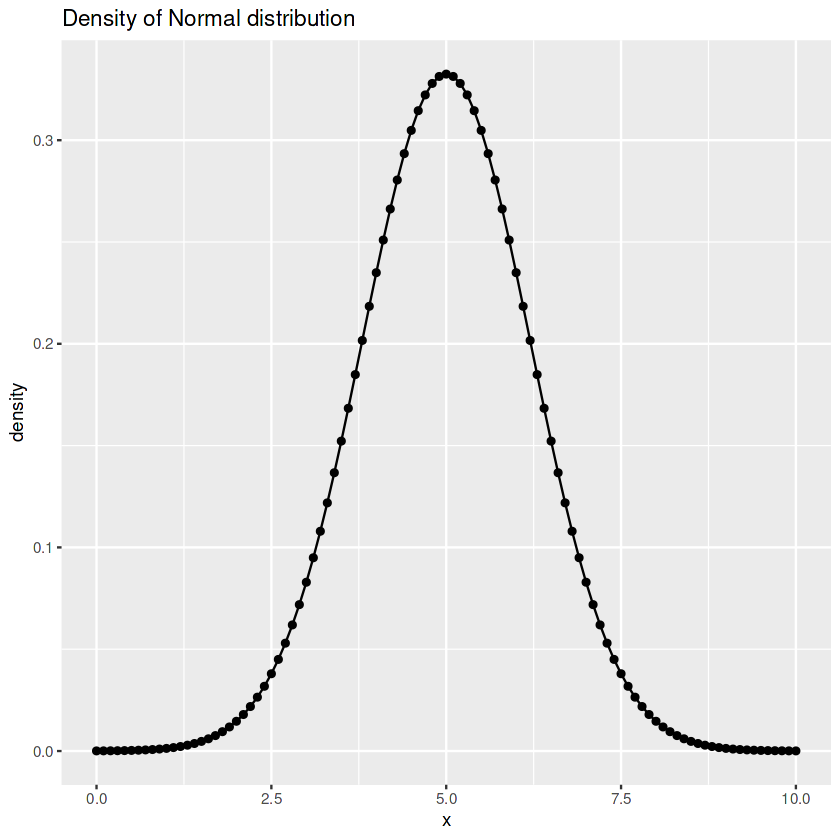

In [10]:
d <- tfd_normal(loc = 5, scale = 1.2)
xs = tf$Variable(seq(0,10,by=0.1), dtype='float32') #We need proper Tensor as x-values
with(tf$GradientTape() %as% t, {
  #In this part of the code stores information (in the tape t) to calculate the gradient
  cdf <- tfd_cdf(d,xs)
})
grads = t$gradient(cdf, xs) #We ask the tape to get gradient of cds w.r.t. xs
xs_vals = xs$numpy() #A working alternative to as.numeric()

data.frame(x=xs_vals,density=as.numeric(grads)) %>%
  ggplot(aes(x=x,y=density)) +
  geom_line() +
  geom_point(data=data.frame(x=xs_vals, y=as.numeric(px)), mapping=aes(x=x,y=y)) +
  ggtitle("Density of Normal distribution") 

## Simulate the fishlike data

**Note: ** Just execute the next cells, if you are nor intested how the toy data is generated. 

In the next few cells you will simulate some (x,y)-data where the y increases on average linearly with x but has non-constant variance that so that scatter plot looks like a fish.You will fist simulate random distributed noise with non constant variance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y = 2.7*x+noise (linear slope of 2.7 and intercept of 0). The variance of the noise will change, it starts with a high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance.

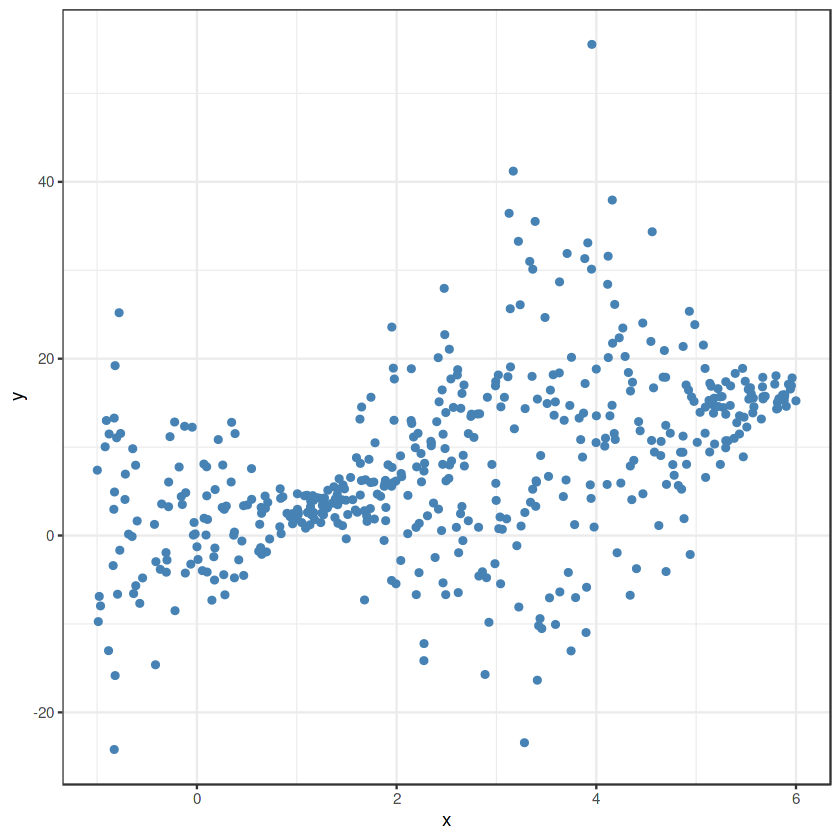

In [11]:
x1 <- seq(1,12,0.1)
x1 <- rev(x1)
x2 <- rep(1,30)
x3 <- seq(1,15,0.1)
x4 <- rep(15,50)
x5 <- rev(x3)
x6 <- rep(1,20)
x <- c(x1,x2,x3,x4,x5,x6)
#plot(x,ylab="sigma")

#Now you will sample uniformly distributed x values in the range from -1 to 6. 
#You will sample less x values in the range from -1 to 1. Finally you sort the x values (for ploting reasons).
set.seed(4710)
noise <- rnorm(length(x),mean = 0,sd = x)
set.seed(99)
first_part=length(x1)
x11 <- runif(first_part,-1,1)
set.seed(97)
x12 <- runif(length(noise)-first_part,1,6)
x <- c(x11,x12)
x <- sort(x)

#Let's put it all together to make the simulated fishlike data complete. 
#You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.
y=2.7*x+noise
tibble(x=x,y=y) %>%
  ggplot(aes(x=x,y=y))+
    geom_point(color="steelblue")+
    theme_bw()

### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. 

In [12]:
idx_train = sample(1:length(y), 0.6*length(y))
idx_test_valid = sample(setdiff(1:length(y), idx_train))
idx_valid = idx_test_valid[1:(length(idx_test_valid)/2)]
idx_test = sample(setdiff(idx_test_valid, idx_valid))
sum(duplicated(c(idx_train, idx_test_valid)))

x_train <- x[idx_train]
y_train <- y[idx_train]

x_test <- x[idx_test]
y_test <- y[idx_test]

x_val <- x[idx_valid]
y_val <- y[idx_valid]

print(paste("nr of training samples = ",length(x_train)))
print(paste("nr of validation samples = ",length(x_val)))
print(paste("nr of test samples = ",length(x_test)))

[1] 0

[1] "nr of training samples =  295"
[1] "nr of validation samples =  99"
[1] "nr of test samples =  99"


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train different models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model. It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction. That is the reason why you will plot it only in the end.


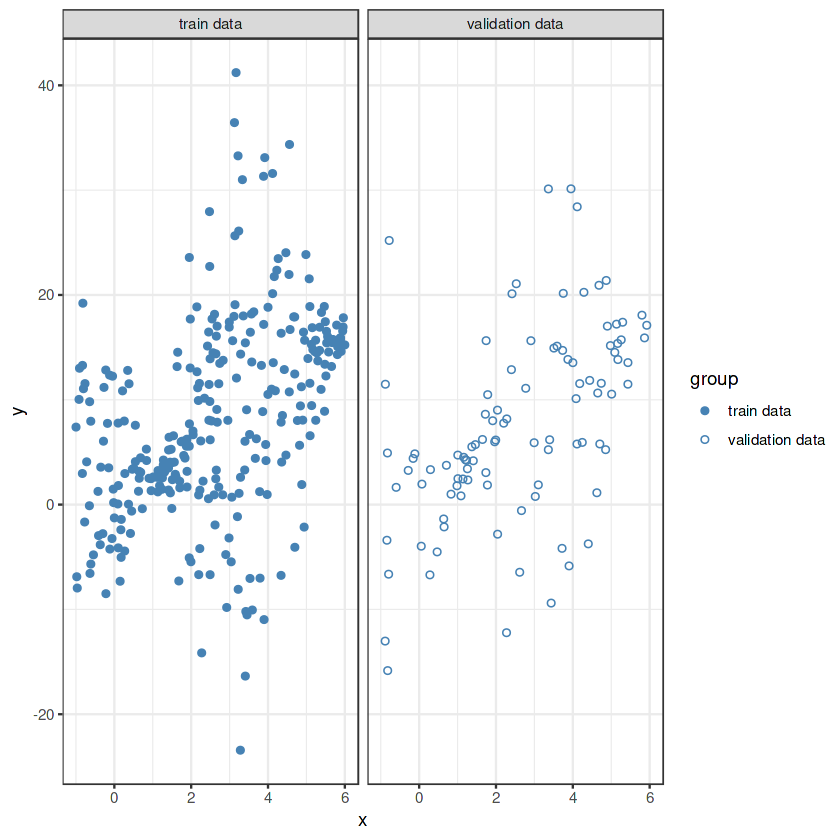

In [13]:
tibble(x=c(x_train,x_val),
       y=c(y_train,y_val),
       group=c(rep("train data",length(x_train)),
             rep("validation data",length(x_val)))
       ) %>%
  ggplot(aes(x=x,y=y,shape=group)) +
  geom_point(color="steelblue") +
  scale_shape_manual(values=c(19,1)) +
  facet_wrap(~group) +
  theme_bw()

## Fit a linear regression model with constant variance

In the next cells you will define and fit a linear model on the simulated fish data with keras. You define a simple linear regression NN with only two parameters to model the output as a gaussian conditional probability distribution , for the loss we use the mse.

In [14]:
inputs = layer_input(shape=c(1))
params = inputs %>%
  layer_dense(units = 1)

model <- keras_model(inputs = inputs, outputs = params)
model %>% compile(
  optimizer = optimizer_adam(lr=0.01),
  loss = 'mse'
)
summary(model)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


Model: "model"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 1)]                     0           
________________________________________________________________________________
dense (Dense)                       (None, 1)                       2           
Total params: 2
Trainable params: 2
Non-trainable params: 0
________________________________________________________________________________


`geom_smooth()` using formula 'y ~ x'



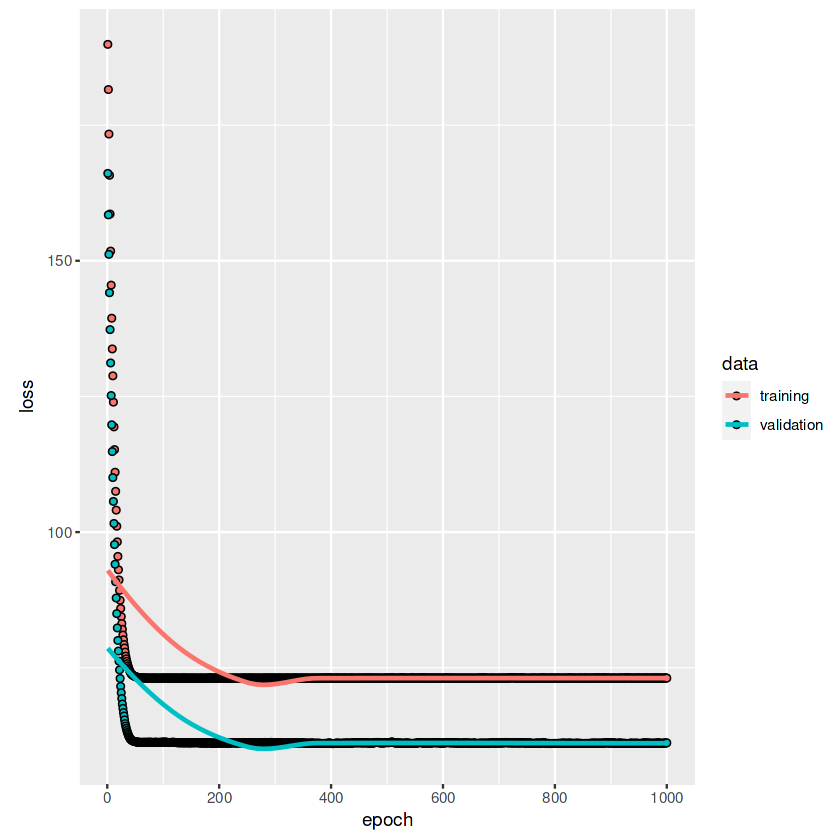

In [15]:
## This should take about 1-2 minutes on a CPU
history <- model %>% 
  fit(x_train, 
      y_train, 
      epochs = 1000,
      verbose=0,
      validation_data = list(x_val, y_val))
plot(history)

To calculate the minimal NLL we need to know the optimal constant sigma that minimizes the NLL. To get the optimal sigma we use the formula for the optimal signma and compute a slightly adjusted standart deviation of the residuals.

In [16]:
preds_train = model %>% predict(x_train)
preds_val = model %>% predict(x_val)

SSR = sum((y_train - preds_train)^2)
sigma = sqrt((SSR)/(length(x_train)- 2))
sigma

[1] 8.578795

To calculate the NLL with the optimal constant sigma, you can use the formula for the $$NLL = \frac{1}{n}\sum_{i=1}^{n}- log(\frac{1}{\sqrt{2 \pi \sigma^2_x}})+\frac{(y_i - \mu_i)^2}{2 \sigma^2_x}$$

In [17]:
#loss with the estimated sigma
NLL_train = mean(-log(1/(sqrt(2*pi*(sigma)^2)))+
                  (((y_train-preds_train)^2/(2*(sigma)^2))))
print(NLL_train)
NLL_val = mean(-log(1/(sqrt(2*pi*(sigma)^2)))+
                (((y_val-preds_val)^2/(2*(sigma)^2))))
print(NLL_val)

[1] 3.564842
[1] 3.48378


Now you will plot the trained model with the resulting mean and +-2 sigma at each x value and see how well it fits the data. Remember in this model you used a linear model for the mean of the CPD and just fixed the standart deviation sigma to a constant value.

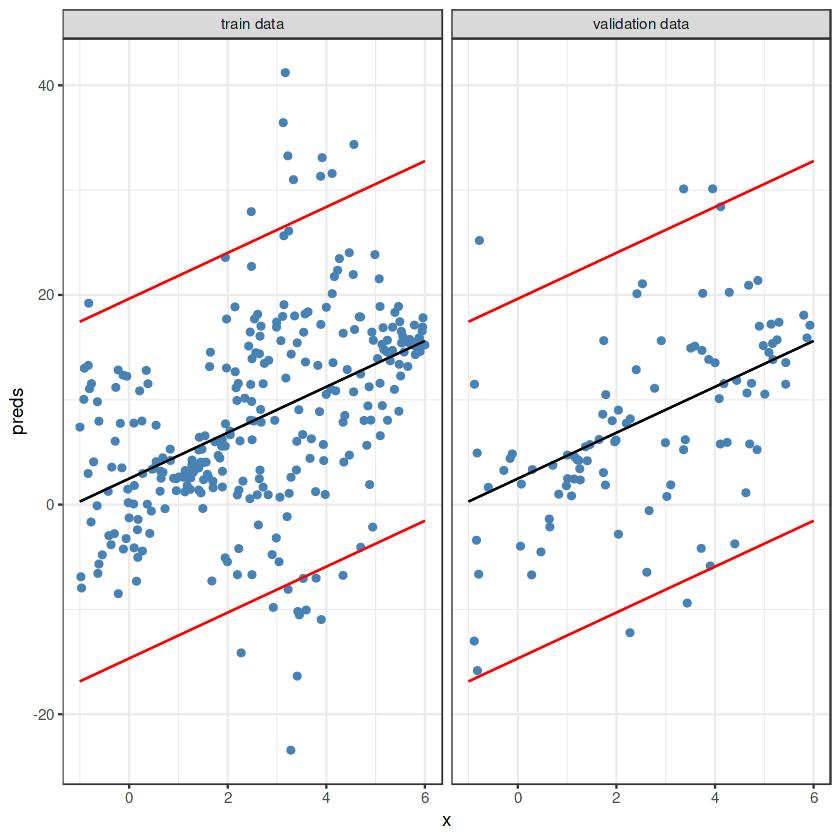

In [18]:
x_pred <- seq(-1,6,0.1)
preds = model %>% predict(x_pred)
tibble(x=x_pred,
       preds=preds,
       upper=preds+2*sigma,
       lower=preds-2*sigma) %>%
  ggplot() +
  geom_line(aes(x=x,y=preds)) +
  geom_line(aes(x=x,y=upper),color="red") +
  geom_line(aes(x=x,y=lower),color="red") +
  geom_point(data=tibble(x=c(x_train,x_val),
                         y=c(y_train,y_val),
                         group=c(rep("train data",length(x_train)),
                                 rep("validation data",length(x_val)))),
             aes(x=x,y=y),color="steelblue") +
  facet_wrap(~group) +
  geom_line(aes(x=x,y=preds)) +
  geom_line(aes(x=x,y=upper),color="red") +
  geom_line(aes(x=x,y=lower),color="red") +
  theme_bw()

## Fit a linear regression model with sd depending in a monotonic way on the input 


Let's try to model the standard deviation sigma in a monotonic way. To define a monotonic standard deviation, you can use a Normal distribution in TFP and you fit both parameters the mean and sigma. You don't use any hidden layers in between. As loss function we use the NLL.



In [19]:
# This cell should take about 1-2 Minutes to run
NLL <- function(y, distr) -tfd_log_prob(distr,y)

my_dist <- function(params) {
  tfd_normal(loc=params[, 1, drop=F], 
             scale = 1e-3 + tf$math$softplus(0.05 * params[, 2, drop=F]))
} # both parameters are learnable #C #D

inputs = layer_input(shape=c(1))
out1 = inputs %>% layer_dense(units = 1)
out2 = inputs %>% layer_dense(units = 1)
params = layer_concatenate(c(out1,out2))

dist = layer_distribution_lambda(params,my_dist)#C #D

model_monotoic_sd <- keras_model(inputs = inputs, outputs = dist)
model_monotoic_sd %>% compile(
  optimizer = optimizer_adam(lr=0.01),
  loss = NLL
)
summary(model_monotoic_sd)
#A Define NLL of the model 
#B Setting up the NN with two output node
#C The first output node defines the mean (loc)
#D The second output defines the standard deviation (scale) via the softplus function
history <- model_monotoic_sd %>% 
  fit(x_train, 
      y_train, 
      epochs = 1000,
      verbose=0,
      validation_data = list(x_val, y_val))

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


Model: "model_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_2 (InputLayer)      [(None, 1)]       0                                   
________________________________________________________________________________
dense_1 (Dense)           (None, 1)         2        input_2[0][0]              
________________________________________________________________________________
dense_2 (Dense)           (None, 1)         2        input_2[0][0]              
________________________________________________________________________________
concatenate (Concatenate) (None, 2)         0        dense_1[0][0]              
                                                     dense_2[0][0]              
________________________________________________________________________________
distribution_lambda (Dist multiple          0        concatenate[0][0]          
Total param

`geom_smooth()` using formula 'y ~ x'



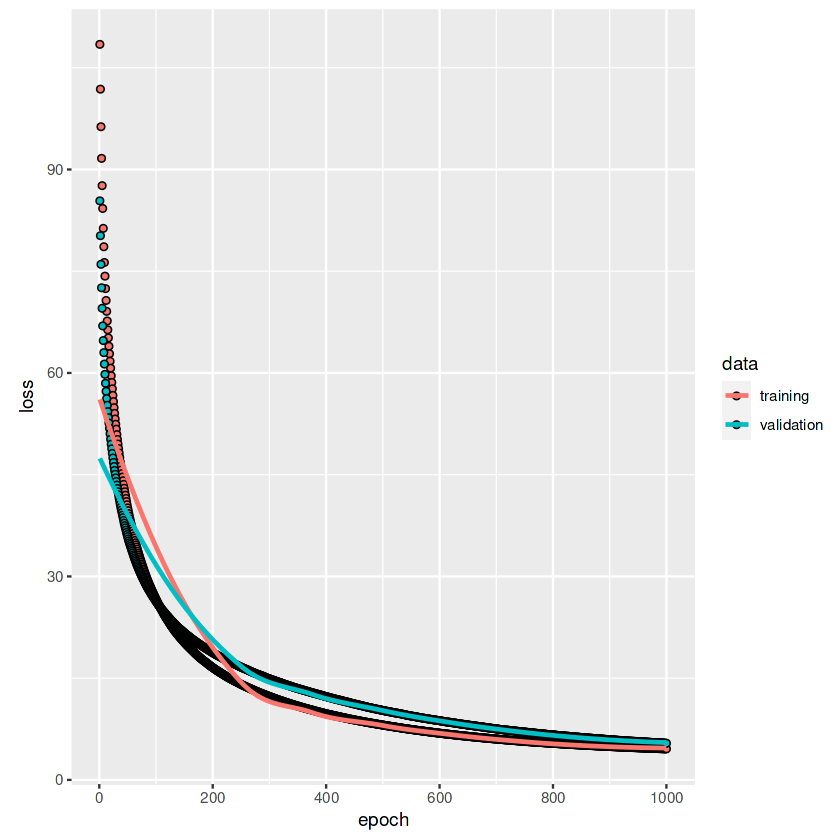

In [20]:
plot(history)

In [21]:
# Evaluation 
print(model_monotoic_sd %>% evaluate(x_train,y_train, verbose=0))
print(model_monotoic_sd %>% evaluate(x_val,y_val, verbose=0))

    loss 
4.574805 
    loss 
5.399395 


### A little technicality / bug accessing the output distribution

The output of `model_monotoic_sd` is a distribution. In python version TFP the following code works
```{python}
    model_monotoic_sd(x_train).mean() #Return the mean (expected) value of the output dist.
    model_monotoic_sd(x_train).std()  #Returns the std 
```

However, in R this currently (Sep 2022) does not work. Note that `predict` always returns a samples from the output distribution. 

In [63]:
#We get samples from the output distrib
predict(model_monotoic_sd, x_pred[1:2]) 
predict(model_monotoic_sd, x_pred[1:2]) 

3.092321
0.717327


1.701226
1.669719


The solution is to build 2 new Keras models, one returning the mean and the other returning the std. Note that the weights stay the same. Instead of sample (which is the default), we now us the mean and the std.

In [69]:
model_monotoic_sd_mean = keras_model(inputs = inputs,
                                     outputs = layer_distribution_lambda(
                                         params, #The two parameters
                                         my_dist,#The distribution fkt
                                         convert_to_tensor_fn = tfp$distributions$Distribution$mean
                                     ))

model_monotoic_sd_sd = keras_model(inputs = inputs,
                                   outputs = layer_distribution_lambda(
                                         params, #The two parameters
                                         my_dist,#The distribution fkt
                                         convert_to_tensor_fn = tfp$distributions$Distribution$stddev
                                     ))

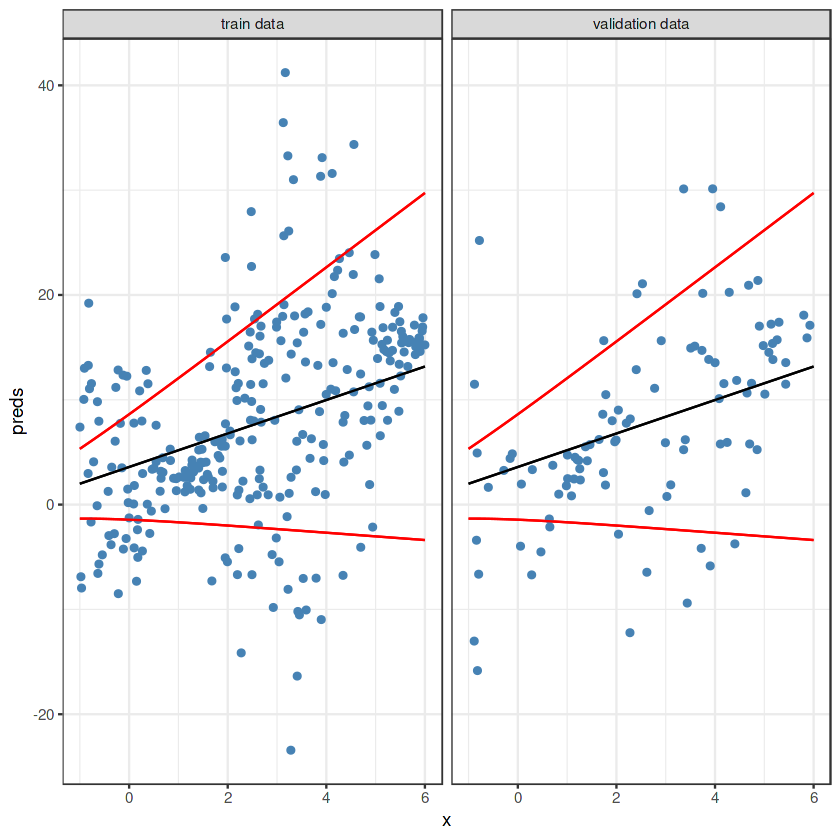

In [70]:
x_pred <- seq(-1,6,0.1)
preds = model_monotoic_sd_mean %>% predict(x_pred)
pred_sd = model_monotoic_sd_sd %>% predict(x_pred)
tibble(x=x_pred,
       preds=preds,
       upper=preds+2*pred_sd,
       lower=preds-2*pred_sd) %>%
  ggplot()+
  geom_line(aes(x=x,y=preds)) +
  geom_line(aes(x=x,y=upper),color="red") +
  geom_line(aes(x=x,y=lower),color="red") +
  geom_point(data=tibble(x=c(x_train,x_val),
                         y=c(y_train,y_val),
                         group=c(rep("train data",length(x_train)),
                                 rep("validation data",length(x_val)))),
             aes(x=x,y=y),color="steelblue") +
  facet_wrap(~group) +
  geom_line(aes(x=x,y=preds)) +
  geom_line(aes(x=x,y=upper),color="red") +
  geom_line(aes(x=x,y=lower),color="red") +
  theme_bw()

Now that you have trained and plotted the model with the resulting mean and +/- 2 sigma at each x value you see how well it fits the data. You see that the standard deviation is not constant but increases with bigger x-values - this is still not describing the data variance very well. The mean of the distribution is still linear because there are no hidden layers in this model. Even if this model is more complex than the ones before, the NLL on the validation set with ~3.5 is unfortunately a bit higher compared to the model with the estimated constant sigma, which had a NLL of ~3.5. The main reason for this is because the simulated variance is not monotonic.

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

From the model with the monotonic standard deviation you probably guessed that you need a model where the standard deviation sigma is non-linear and able to increase for some x-values but then again decrease for others. Remember how the data was simulated. Let's try that and see if we can decrease the NLL below ~3.5. You will now define and fit a model that models the mean of the normal distribution linearly (no hidden layer for the mean parameter) but for the standard devation sigma, you will use 3 hidden layers in beetween (with 50 ,100 and 50 nodes). Because of the hidden layers the resulting standart deviation is now able to change non-linarly with x, if necessary. You will use again TFP and keras for the model definition. The loss function you use is again the NLL.


**Question**: How would you extend the code from simple model above
```
inputs = layer_input(shape=c(1))
out1 = inputs %>% layer_dense(units = 1)
out2 = inputs %>% layer_dense(units = 1)
params = layer_concatenate(c(out1,out2))
```

To allow that the variance can depend in a flexible manner on the input. Try before looking at the solution.
.

.

.

.

.

.




In [71]:
NLL <- function(y, distr) -tfd_log_prob(distr,y)

my_dist <- function(params) {
  tfd_normal(loc=params[, 1, drop=F],
             scale = 1e-3 + tf$math$softplus(0.05 * params[, 2,  drop=F]))
}                                       
# both parameters are learnable #C #D

inputs = layer_input(shape=c(1))
out1 = inputs %>% #A
  layer_dense(units = 1)
hidden1 = inputs %>%
  layer_dense(units = 20, activation = "relu")
hidden2 = hidden1 %>%
  layer_dense(units = 30, activation = "relu")
hidden3 = hidden2 %>%
  layer_dense(units = 20, activation = "relu")
out2 = hidden3 %>% #B
  layer_dense(units = 1, activation = "linear")
params = layer_concatenate(c(out1,out2)) #C
dist = layer_distribution_lambda(params, my_dist)

model_flex_sd <- keras_model(inputs = inputs, outputs = dist)
model_flex_sd %>% 
  compile(
    optimizer = optimizer_adam(lr=0.01),
    loss = NLL
    )
summary(model_flex_sd)
# A The first output models the mean, no hidden layers are used
# B The second output models the spread of the distribution. 
#   Three hidden layers are used for it
# C Combining the outputs for the mean and the spread
history <- model_flex_sd %>% 
  fit(x_train, 
      y_train, 
      epochs = 2000,
      verbose=1,
      validation_data = list(x_val, y_val))

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


Model: "model_11"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_3 (InputLayer)      [(None, 1)]       0                                   
________________________________________________________________________________
dense_4 (Dense)           (None, 20)        40       input_3[0][0]              
________________________________________________________________________________
dense_5 (Dense)           (None, 30)        630      dense_4[0][0]              
________________________________________________________________________________
dense_6 (Dense)           (None, 20)        620      dense_5[0][0]              
________________________________________________________________________________
dense_3 (Dense)           (None, 1)         2        input_3[0][0]              
________________________________________________________________________________
dense_7 (D

   loss 
3.17798 
    loss 
3.143251 


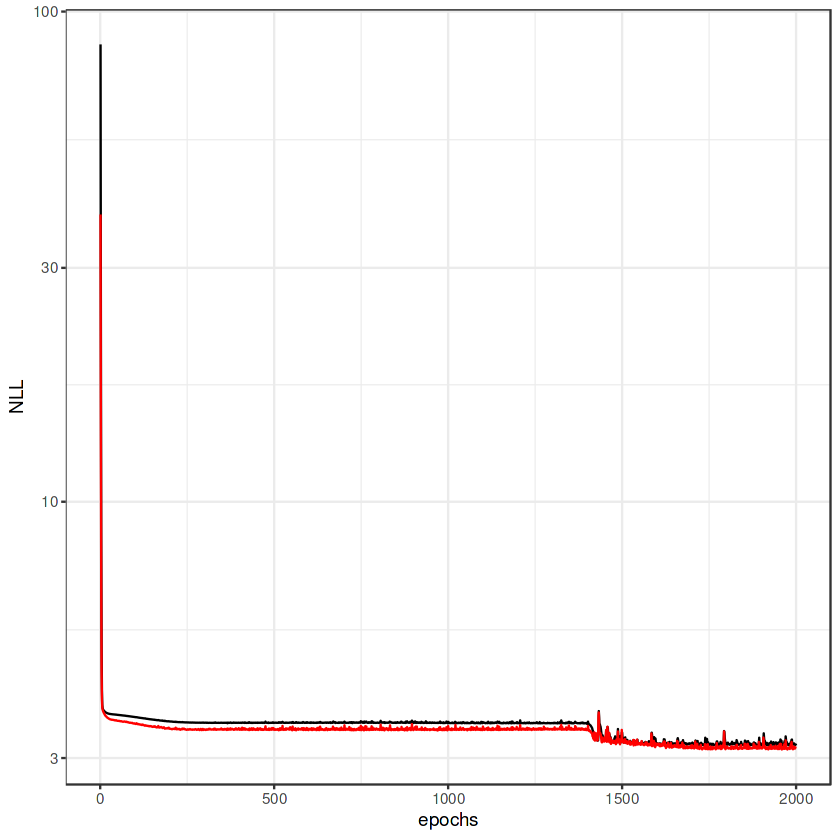

In [72]:
tibble(epochs = 1:2000,
       loss = history$metrics$loss,
       val_loss = history$metrics$val_loss) %>%
  ggplot() +
  geom_line(aes(x=epochs,y=loss)) +
  geom_line(aes(x=epochs,y=val_loss), color="red") +
  ylab("NLL") + 
  scale_y_log10() +
  theme_bw()

print(model_flex_sd %>% evaluate(x_train,y_train, verbose=0))
print(model_flex_sd %>% evaluate(x_val,y_val, verbose=0))

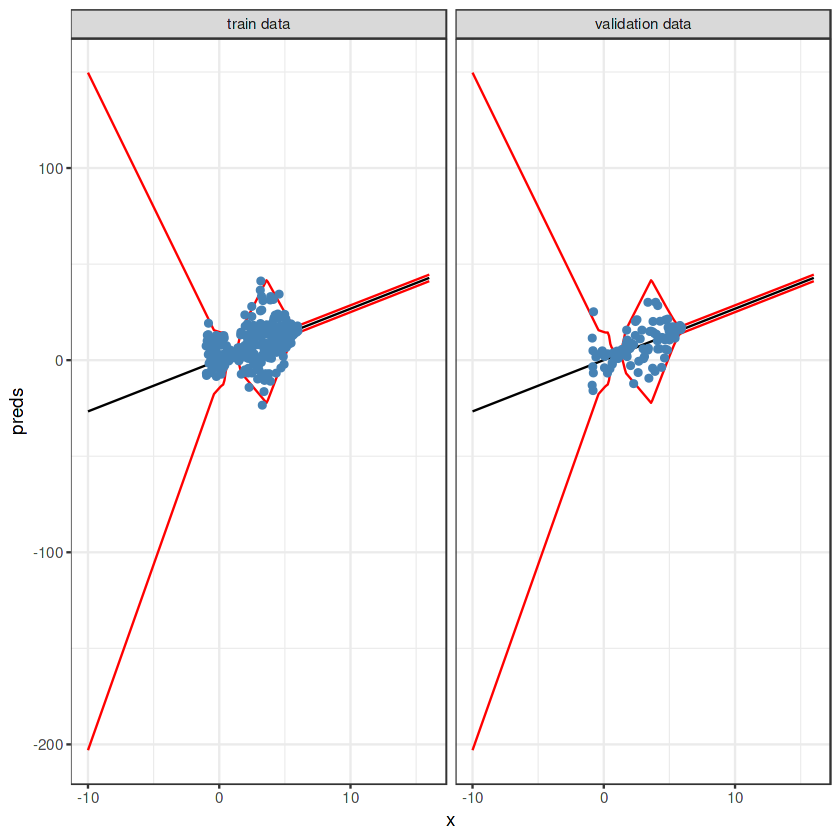

In [73]:
model_flex_sd_mean = keras_model(inputs = inputs,
                                     outputs = layer_distribution_lambda(
                                         params, #The two parameters
                                         my_dist,#The distribution fkt
                                         convert_to_tensor_fn = tfp$distributions$Distribution$mean
                                     ))

model_flex_sd_sd = keras_model(inputs = inputs,
                                   outputs = layer_distribution_lambda(
                                         params, #The two parameters
                                         my_dist,#The distribution fkt
                                         convert_to_tensor_fn = tfp$distributions$Distribution$stddev
                                     ))

x_pred <- seq(-10,16,0.1)
preds = model_flex_sd_mean %>% predict(x_pred)
pred_sd = model_flex_sd_sd %>% predict(x_pred)
d_plot = tibble(x=x_pred,
       preds=preds,
       upper=preds + 2*pred_sd,
       lower=preds - 2*pred_sd)
d_plot  %>%
  ggplot() +
  geom_line(aes(x=x,y=preds)) +
  geom_line(aes(x=x,y=upper),color="red") +
  geom_line(aes(x=x,y=lower),color="red") + 
  geom_point(data=tibble(x=c(x_train,x_val),
                         y=c(y_train,y_val),
                         group=c(rep("train data",length(x_train)),
                                 rep("validation data",length(x_val)))),
             aes(x=x,y=y),color="steelblue") +
  facet_wrap(~group)+
  # geom_line(aes(x=x,y=preds)) +
  # geom_line(aes(x=x,y=upper),color="red") +
  # geom_line(aes(x=x,y=lower),color="red") +
  theme_bw()

# Additional Task

 <img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*1. Extend the x-range from -5 to +15 and redo the analysis, what do you observe?*

*2. Choose the best model and make a predition on the testset*


In [74]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] tfprobability_0.15.1 tensorflow_2.9.0     keras_2.6.0         
 [4] reticulate_1.26      forcats_0.5.2        stringr_1.4.1       
 [7] dplyr_1.0.10         purrr_0.3.4          readr_2.1.2         
[10] tidyr_1.2.1          tibble_3.1.8         ggp